<a href="https://colab.research.google.com/github/VijayRameshkumar/ChitFund/blob/master/object_detect_for_i3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U --pre tensorflow=="2.*"
!pip install sk-video
import cv2
import imutils
import numpy as np
from PIL import Image
import sys
import time
import pandas as pd
import os
import glob
import math
from google.colab.patches import cv2_imshow

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.1.0rc1)


Make sure you have `pycocotools` installed

In [3]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [6]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017523 sha256=87cc7e7930c97a1dd1d74cd931086bc590223de711ea5c7c0a3234f6f348d024
  Stored in directory: /tmp/pip-ephem-wheel-cache-i5vcmdz_/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


### Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [12]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

# Detection

Load an object detection model:

In [13]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [14]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [15]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [16]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

Add a wrapper function to call the model, and cleanup the outputs:

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.3,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)

  persons_index = list(np.where(output_dict['detection_classes'] == 1))
  classes = output_dict['detection_classes'][persons_index]
  bboxes = output_dict['detection_boxes'][persons_index]
  confidence = output_dict['detection_scores'][persons_index]
  # print('Number of Person is: ', len(persons_index))
  # return classes, confidence, bboxes

  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  return Image.fromarray(image_np), bboxes, confidence

In [0]:
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3)]
# for image_path in TEST_IMAGE_PATHS:
#   print(show_inference(detection_model, image_path))


The instance segmentation model includes a `detection_masks` output:

In [0]:
################################ Videos_TO_Frames #####################################

vidcap = cv2.VideoCapture('/content/sample_data/miami_cops.mp4')

def getFrame(sec):

    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,frame = vidcap.read()

    if hasFrames:

      # new_width  = 224
      # new_height = 224

      # frame = cv2.resize(frame, (new_width, new_height))

      # frame = imutils.rotate(frame, angle=-90)
        
      cv2.imwrite("/content/sample_data/Frames1/{}.jpg".format(count), frame)    # save frame as JPG file

      return hasFrames

sec = 0
frameRate = 0.5 #//it will capture image in each 0.1 second #60 FPS
count=0
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

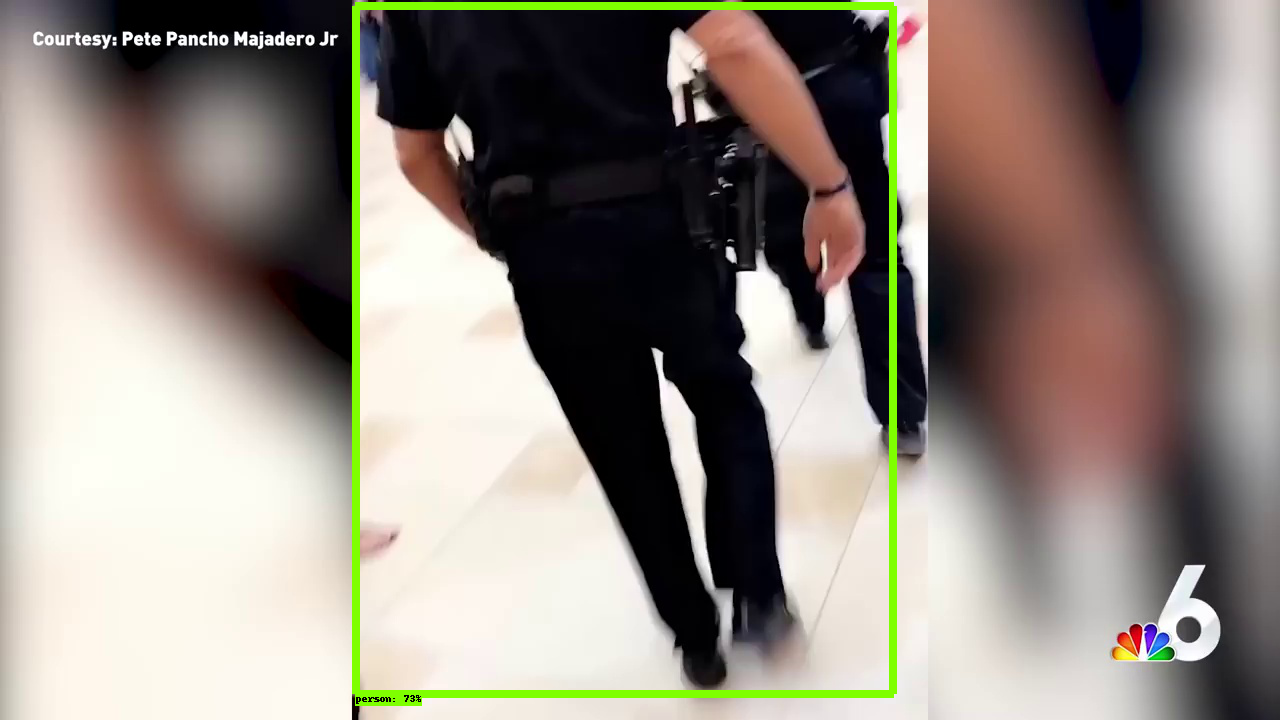

None [[0.00841715931892395, 0.27768635749816895, 0.9632161855697632, 0.698344349861145]] 
 1 (1280, 720)


In [27]:
################### FRAMES TO PREDICTION #############################

TEST_IMAGE_PATHS = list()
count = 0

extension = 'jpg'

for i in glob.glob('/content/sample_data/Frames1/' + '*.{}'.format(extension)):
  TEST_IMAGE_PATHS.append(i)
  count = len(TEST_IMAGE_PATHS)

################### FRAMES ORDERING ####################################

df = pd.DataFrame(TEST_IMAGE_PATHS, columns=['Path'])

def order(x):
  extension = 'jpg'
  x = str(x)
  x = x.split('.')[0]
  x = x.split('/')[-1]
  return x

df['order'] = df['Path'].apply(order).astype(int)
df = df.sort_values(by='order').reset_index(drop=True)
ordered_frames = df['Path'].tolist()
  
##################### BOUNDING BOX IMAGES ##########################
frame_count = 0
for image_path in ordered_frames:

  frame_count+=1

  images, bboxes, confidences = show_inference(detection_model, image_path) # getting return value from function

  bboxes = bboxes.tolist()

  prob_index = [i for i in range(len(confidences)) if confidences[i] >= 0.5] #Propability index

  bbox_coords = [bboxes[i] for i in prob_index] # Retreiving BBOX co-ord by index

  print(display(images), bbox_coords, '\n', frame_count, images.size)
  break


In [38]:
def roi(img, coords, widht, height):

  cropped_items = []

  for items in coords:

    img = np.array(img)
  
    ymin = int(items[0] * height)
    xmin = int(items[1] * width)
    ymax = int(items[2] * height)
    xmax = int(items[3] * width)
    
    crop = img[ymin:ymax, xmin:xmax]

    cropped_items.append(crop)
  
  return cropped_items

############################### Main PROGRAM ############################

frame_count = 0

videos = []

for image_path in ordered_frames:

  frame_count+=1

  images, bboxes, confidences = show_inference(detection_model, image_path) # getting return value from function

  bboxes = bboxes.tolist()

  prob_index = [i for i in range(len(confidences)) if confidences[i] >= 0.5] #Propability index

  bbox_coords = [bboxes[i] for i in prob_index] # Retreiving BBOX co-ord by index

  width, height = images.size

  region_of_interest = roi(images, bbox_coords, width, height)

  videos.append(region_of_interest)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [47]:
pre_processed_videos = []

for i in videos:

  for j in i:

    images = j[:, :, [2, 1, 0]]

    # images = cv2_imshow(j[:, :, [2, 1, 0]])

    images = cv2.resize(images, (224,224))

    pre_processed_videos.append(images)

print(len(pre_processed_videos))

320


In [0]:
outvid = 'output.avi'

fourcc = cv2.VideoWriter.fourcc(*'MJPG')

vid = cv2.VideoWriter(outvid, fourcc, float(4), (224,224), True)

for i in pre_processed_videos:
  vid.write(i[:, :, [2, 1, 0]])
vid.release()

In [57]:
!pip install sk-video
import skvideo.io

outputdata = np.asarray(pre_processed_videos)
outputdata = outputdata.astype(np.uint8)
skvideo.io.vwrite("outputvideo2.mp4", outputdata)